### Question 4: 40 marks (Implement, evaluate, and understand the impact of GNN variations) The goal of this exercise is to encourage a research temper: running experiments, analyzing outputs, drawing inferences, and deciding next steps. You may use the base libraries of pytorch or tensorflow. However, directly using graph libraries for implementing the models (e.g., pytorch- geometric) is not allowed. You may use the graph libraries for helping with data loading or other non-model specific parts. Training some of the models below may take some computation time, so get started sooner than later. Copying from one another is not ok. Reading papers is encouraged. Acknowledge all your tools and sources. We recommend experiments be performed on a simple dataset such as Cora/Citeseer. These work on a standard CPU laptop. Use standard splits (see https://arxiv.org/abs/1710.10903). Your output can be a Jupyter notebook (that we can run) that is self -contained, reproducible, includes a thorough analysis, has appropriate comments, and answers to various questions in Markdown / code / plots as appropriate.

### Explain the characteristics of the dataset. What is the task? What are the number of features, outputs? Where are the features derived from? What are some typical graph properties – node degree?

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, total_classes, num_layers=2):
        super(GNN, self).__init__()
        self.num_layers = num_layers
        self.aggregation = nn.Linear(input_dim, hidden_dim)
        self.update = nn.Linear(hidden_dim, hidden_dim)
        self.classifier = nn.Linear(hidden_dim, total_classes)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.aggregation.weight)
        nn.init.xavier_uniform_(self.update.weight)
        nn.init.xavier_uniform_(self.classifier.weight)

    def forward(self, adj, feature_mat):
        for _ in range(self.num_layers):
            aggregation_mat = torch.matmul(adj, feature_mat)
            aggregation_mat = self.aggregation(aggregation_mat)
            aggregation_mat = F.relu(aggregation_mat)

            update_mat = self.update(feature_mat)
            feature_mat = F.relu(aggregation_mat + update_mat)

        output = self.classifier(feature_mat)
        return output


In [ ]:
# # Q4; only for 1 layer
# class GNN(nn.Module):
#   def __init__(self, input_dim, hidden_dim, total_classes):
#     super(GNN, self).__init__()
#     self.aggregate_1 = nn.Linear(input_dim, hidden_dim)
#     self.update_1 = nn.Linear(input_dim, hidden_dim)

#     self.aggregate_2 = nn.Linear(hidden_dim, total_classes)
#     self.update_2 = nn.Linear(hidden_dim, total_classes)

#     self.initialize()

#   def initialize(self):
#     return

#   def aggregate(self, adj, feature_mat, aggr_fn):
#     aggregation_mat = aggr_fn(torch.matmul(adj, feature_mat))
#     return aggregation_mat

#   def update(self, feature_mat, aggregation_mat, combine_fn):
#     feature_mat = F.relu(combine_fn(feature_mat) + aggregation_mat)
#     return feature_mat

#   def forward(self, adj, feature_mat): # considering adj is symmetric matrix
#     aggregation_mat = self.aggregate(adj, feature_mat, self.aggregate_1)
#     feature_mat =  self.update(feature_mat, aggregation_mat, self.update_1)

#     aggregation_mat = self.aggregate(adj, feature_mat, self.aggregate_2)
#     feature_mat =  self.update(feature_mat, aggregation_mat, self.update_2)

#     return feature_mat

In [45]:
class BaseGNN(nn.Module):
  def __init__(self, input_dim, total_classes):
    super(BaseGNN, self).__init__()
    self.aggregate_1 = nn.Linear(input_dim, total_classes)
    self.update_1 = nn.Linear(input_dim, total_classes)

  def aggregate(self, adj, feature_mat, aggr_fn):
    aggregation_mat = aggr_fn(torch.matmul(adj, feature_mat))
    return aggregation_mat

  def update(self, feature_mat, aggregation_mat, combine_fn):
    feature_mat = F.relu(combine_fn(feature_mat) + aggregation_mat)
    return feature_mat

  def forward(self, adj, feature_mat):
    aggregation_mat = self.aggregate(adj, feature_mat, self.aggregate_1)
    feature_mat =  self.update(feature_mat, aggregation_mat, self.update_1)

    return feature_mat


In [49]:
class GCN(BaseGNN):
  def __init__(self, num_layers, input_dim, hidden_dims, total_classes, dropout_prob = 0.1):
    super(GCN, self).__init__(input_dim, total_classes)

    self.linear_layers = nn.ModuleList()

    self.num_layers = num_layers
    if dropout_prob is not None:
      self.dropout = nn.Dropout(p = dropout_prob)

    self.dropout_prob = dropout_prob

    for i in range(self.num_layers):
      if i == 0:
        self.linear_layers.append(nn.Linear(input_dim, hidden_dims[0]))
      else:
        self.linear_layers.append(nn.Linear(hidden_dims[i - 1], hidden_dims[i]))

  def forward(self, feature_matrix, adjacency_matrix):
    # Compute node degrees
    sqrt_node_degrees = torch.sqrt(torch.sum(adjacency_matrix, dim = 1))

    # Add self-loop to adjacency matrix
    adjacency_matrix = adjacency_matrix + torch.eye(adjacency_matrix.shape[0])

    for i, linear_layer in enumerate(self.linear_layers):
      # Divide feature_matrix by sqrt(node)
      feature_matrix = (feature_matrix.T / sqrt_node_degrees).T

      # Aggregation and update
      aggregation_matrix = (torch.matmul(adjacency_matrix, feature_matrix).T / sqrt_node_degrees).T

      # Pass through linear layer
      feature_matrix = F.relu(linear_layer(aggregation_matrix))

      # Apply dropout if not the last layer
      if self.dropout_prob is not None and i < self.num_layers - 1:
        feature_matrix = self.dropout(feature_matrix)

    return feature_matrix


In [4]:
!pip install torch-geometric -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.6 MB/s eta 0:00:00


In [5]:
# load datasets
import os
import numpy as np
import pandas as pd
from torch_geometric.datasets import Planetoid
from networkx.algorithms import community
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
import torch_geometric

data_dir = "./data"
os.makedirs(data_dir, exist_ok=True)

In [7]:
dataset = Planetoid(root=data_dir, name='Cora')
data = dataset[0]

Processing...
Done!



The dataset you are using is the Cora dataset, which is a popular benchmark dataset for node classification in graph-based machine learning tasks. Here are the characteristics of the dataset:

Task: The task is node classification, where the goal is to predict the category (or class) of each node in the graph. In the case of the Cora dataset, nodes represent scientific publications, and the task is to predict the research area (class) of each publication.

Number of Features: Each node (publication) in the Cora dataset is represented by a 1433-dimensional feature vector. These features are binary indicators representing the presence or absence of certain words in the corresponding publication's abstract.

Number of Outputs: The Cora dataset has seven predefined classes (research areas), so the node classification task is a multi-class classification problem with seven possible output classes.

Feature Source: The features in the Cora dataset are derived from the bag-of-words representation of the publication abstracts. Each word in the vocabulary is assigned a unique index, and the feature vector for a publication is a binary vector indicating the presence or absence of each word in the abstract.

Graph Properties: The Cora dataset is represented as a citation network, where nodes are publications and edges represent citations between publications. One typical graph property is the node degree, which represents the number of edges (citations) incident to a node (publication). In the context of the Cora dataset, node degree can indicate the influence or importance of a publication within the citation network.

Overall, the Cora dataset is a well-known dataset used for evaluating graph-based machine learning models, particularly for node classification tasks. Its features are derived from publication abstracts, and it exhibits typical properties of citation networks.

In [8]:
print(f'Dataset: {dataset}:')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

print('\nGraph information:')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')

G = to_networkx(data, to_undirected=True)
degrees = [val for (node, val) in G.degree()]
print(f'Number of classes: {dataset.num_classes}')


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Graph information:
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Has isolated nodes: False
Has self-loops: False
Is undirected: True
Average node degree: 3.90
Number of classes: 7


In [ ]:
# print(f'Dataset: {dataset}:')
# print(f'Number of graphs: {len(dataset)}')
# print(f'Number of features: {dataset.num_features}')
# print(f'Number of classes: {dataset.num_classes}')

# print('\nGraph information:')
# print(f'Number of nodes: {data.num_nodes}')
# print(f'Number of edges: {data.num_edges}')
# print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
# print(f'Has isolated nodes: {data.has_isolated_nodes()}')
# print(f'Has self-loops: {data.has_self_loops()}')
# print(f'Is undirected: {data.is_undirected()}')
# print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')

# G = to_networkx(data, to_undirected=True)
# degrees = [val for (node, val) in G.degree()]
# print(f'Number of classes: {dataset.num_classes}')


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Graph information:
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Has isolated nodes: False
Has self-loops: False
Is undirected: True
Average node degree: 3.90
Number of classes: 7


In [12]:
import networkx as nx
import torch

# Assuming G is a NetworkX graph
adj = nx.adjacency_matrix(G)
adj = torch.tensor(adj.toarray(), dtype=torch.float32)

print(adj.shape)


torch.Size([2708, 2708])


In [ ]:
# # get adjacency matrix
# import networkx as nx

# adj = nx.adjacency_matrix(G)
# adj = torch.tensor(adj.toarray())

# print(adj.shape)


In [13]:
# get adjacency matrix
import networkx as nx

adj = nx.adjacency_matrix(G)
adj = torch.tensor(adj.toarray())

print(adj.shape)


torch.Size([2708, 2708])


In [14]:
data, data.train_mask

(Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708]),
 tensor([ True,  True,  True,  ..., False, False, False]))

In [16]:
print(len(data.x[0]), data.x[0], data.y[:10])


1433 tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([3, 4, 4, 0, 3, 2, 0, 3, 3, 2])


In [17]:
feature_mat = data.x
print("Node Features Shape:", feature_mat.shape)

labels = data.y
print("Node Labels Shape:", labels.shape)

train_mask = data.train_mask
val_mask = data.val_mask
test_mask = data.test_mask

print("Train Mask Shape:", train_mask.shape)
print("Validation Mask Shape:", val_mask.shape)
print("Test Mask Shape:", test_mask.shape)


Node Features Shape: torch.Size([2708, 1433])
Node Labels Shape: torch.Size([2708])
Train Mask Shape: torch.Size([2708])
Validation Mask Shape: torch.Size([2708])
Test Mask Shape: torch.Size([2708])


In [ ]:
# feature_mat = data.x
# print(feature_mat.shape)

# labels = data.y
# print(labels.shape)

# train_mask = data.train_mask
# val_mask = data.val_mask
# test_mask = data.test_mask

# print("Train mask shape - ", train_mask.shape)
# print("Val mask shape - ", val_mask.shape)
# print("Test mask shape - ", test_mask.shape)


torch.Size([2708, 1433])
torch.Size([2708])
Train mask shape -  torch.Size([2708])
Val mask shape -  torch.Size([2708])
Test mask shape -  torch.Size([2708])


In [57]:
# from sklearn.metrics import accuracy_score

# def start_train(no_of_layers, input_dim, hidden_dims, total_classes, train_mask, val_mask, test_mask, adj, drop_prob):
#   model = GCN(no_of_layers, input_dim, hidden_dims, total_classes, drop_prob)
#   optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#   loss_fn = nn.CrossEntropyLoss()

#   epochs = 20
#   train_loss_vals = []
#   val_loss_vals = []

#   for epoch in range(epochs):
#     print(f"EPOCH - {epoch + 1}")
#     model.train()
#     optimizer.zero_grad()

#     logits = model(feature_mat, adj)
#     loss = loss_fn(logits[train_mask], labels[train_mask])
#     loss.backward()
#     optimizer.step()

#     train_loss_vals.append(loss.item())

#     # do evaluation on validation loss
#     model.eval()
#     with torch.no_grad():
#       val_loss = loss_fn(logits[val_mask], labels[val_mask])
#       val_loss_vals.append(val_loss.item())

#     print(f"Training Loss {loss.item()}, Validation Loss {val_loss.item()}")
#     print("-----------------------------------")

#   model.eval()
#   with torch.no_grad():
#     logits = model(feature_mat, adj)
#     test_logits = logits[test_mask]
#     actual_labels = labels[test_mask]

#     test_acc = accuracy_score(actual_labels.numpy(), test_logits.argmax(dim = 1).numpy())

#   return train_loss_vals, val_loss_vals, test_acc



In [61]:
from sklearn.metrics import accuracy_score

def start_train(num_layers, input_dim, hidden_dims, total_classes, train_mask, val_mask, test_mask, adj, drop_prob):
  model = GCN(num_layers, input_dim, hidden_dims, total_classes, drop_prob)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  loss_fn = nn.CrossEntropyLoss()

  epochs = 20
  train_loss_vals = []
  val_loss_vals = []

  for epoch in range(epochs):
    print(f"EPOCH - {epoch + 1}")
    model.train()
    optimizer.zero_grad()

    logits = model(feature_mat, adj)
    loss = loss_fn(logits[train_mask], labels[train_mask])
    loss.backward()
    optimizer.step()

    train_loss_vals.append(loss.item())

    # Evaluate on validation loss
    model.eval()
    with torch.no_grad():
      val_loss = loss_fn(logits[val_mask], labels[val_mask])
      val_loss_vals.append(val_loss.item())

    print(f"Training Loss {loss.item()}, Validation Loss {val_loss.item()}")
    print("-"*80)

  model.eval()
  with torch.no_grad():
    logits = model(feature_mat, adj)
    test_logits = logits[test_mask]
    actual_labels = labels[test_mask]

    test_acc = accuracy_score(actual_labels.numpy(), test_logits.argmax(dim=1).numpy())

  return train_loss_vals, val_loss_vals, test_acc


In [62]:
def train_for_setting(layer_setting, hidden_dim_setting, input_dim, total_classes, adj, feature_mat, train_mask, val_mask, test_mask, drop_prob):
    train_loss, val_loss, test_acc_score = [], [], []

    for no_of_layers, hidden_dims in zip(layer_setting, hidden_dim_setting):
        print(f"Initiating for setting - {no_of_layers} with Hidden Dims {hidden_dims}")
        train_loss_vals, val_loss_vals, test_acc = start_train(no_of_layers, input_dim, hidden_dims, total_classes,
                                                               train_mask, val_mask, test_mask,
                                                               adj, drop_prob)

        train_loss.append(train_loss_vals)
        val_loss.append(val_loss_vals)
        test_acc_score.append(test_acc)

        print("="*80)

    return train_loss, val_loss, test_acc_score


In [63]:
no_of_layers = [1,2,5]
hidden_dims = [[7], [500, 7], [750, 350, 175, 85, 7]]
dropout_prob = 0.01
input_dim = 1433
total_classes = 7

torch.manual_seed(42)

train_loss, val_loss, test_acc_score = train_for_setting(no_of_layers, hidden_dims, input_dim,
                                                         total_classes, adj, feature_mat, train_mask,
                                                         val_mask, test_mask, dropout_prob)

Initiating for setting - 1 with Hidden Dims [7]
EPOCH - 1
Training Loss 1.9489153623580933, Validation Loss 1.9420157670974731
--------------------------------------------------------------------------------
EPOCH - 2
Training Loss 1.9396743774414062, Validation Loss 1.938591718673706
--------------------------------------------------------------------------------
EPOCH - 3
Training Loss 1.9314172267913818, Validation Loss 1.9355446100234985
--------------------------------------------------------------------------------
EPOCH - 4
Training Loss 1.9236781597137451, Validation Loss 1.9325199127197266
--------------------------------------------------------------------------------
EPOCH - 5
Training Loss 1.9158177375793457, Validation Loss 1.9294450283050537
--------------------------------------------------------------------------------
EPOCH - 6
Training Loss 1.907158374786377, Validation Loss 1.9260674715042114
---------------------------------------------------------------------------

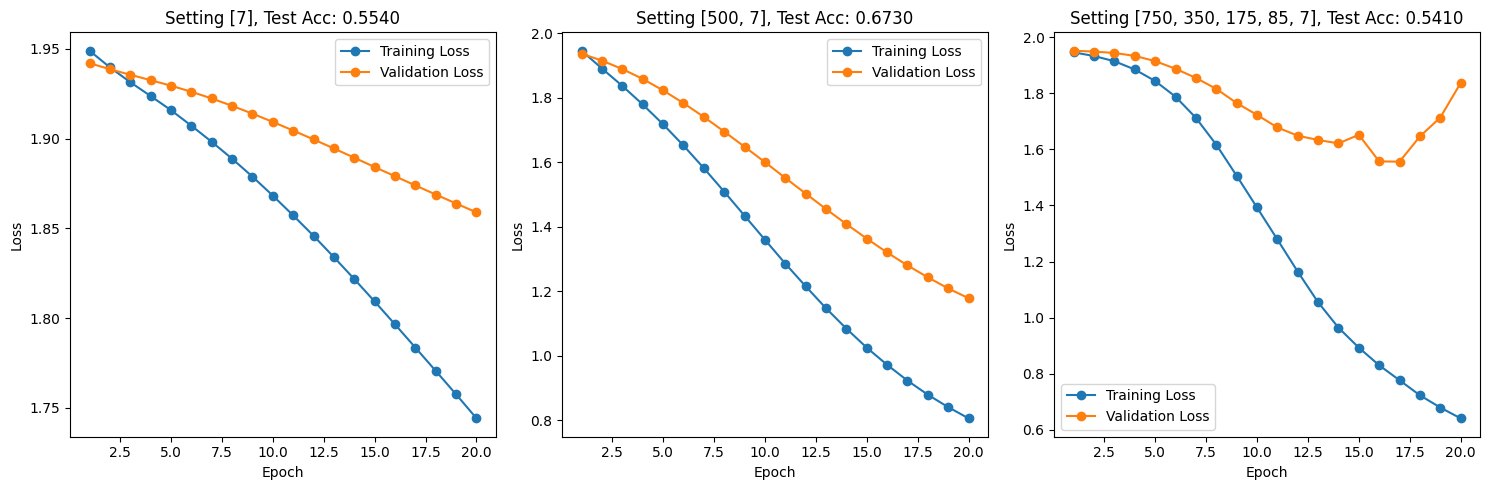

In [64]:
import matplotlib.pyplot as plt

# Assuming test_acc_score is a list containing accuracy scores for each setting
plt.subplots(1, 3, figsize=(15, 5))

for idx in range(len(test_acc_score)):
    plt.subplot(1, 3, idx + 1)
    plt.plot(
        range(1, 1 + len(train_loss[idx])),
        train_loss[idx],
        marker='o',
        label="Training Loss"
    )

    plt.plot(
        range(1, 1 + len(val_loss[idx])),
        val_loss[idx],
        marker='o',
        label="Validation Loss"
    )

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"Setting {hidden_dims[idx]}, Test Acc: {test_acc_score[idx]:.4f}")

plt.tight_layout()
plt.show()


In [66]:
# test accuracy
for i, acc in zip(hidden_dims, test_acc_score):
  print(f"Under Setting {i}, test accuracy - {acc}")
  print("="*80)

Under Setting [7], test accuracy - 0.554
Under Setting [500, 7], test accuracy - 0.673
Under Setting [750, 350, 175, 85, 7], test accuracy - 0.541


Initiating for setting - 1 with Hidden Dims [7]
EPOCH - 1
Training Loss 1.9544503688812256, Validation Loss 1.9477523565292358
--------------------------------------------------------------------------------
EPOCH - 2
Training Loss 1.9417811632156372, Validation Loss 1.9433586597442627
--------------------------------------------------------------------------------
EPOCH - 3
Training Loss 1.9301131963729858, Validation Loss 1.9395557641983032
--------------------------------------------------------------------------------
EPOCH - 4
Training Loss 1.9193073511123657, Validation Loss 1.9359948635101318
--------------------------------------------------------------------------------
EPOCH - 5
Training Loss 1.9089471101760864, Validation Loss 1.9325286149978638
--------------------------------------------------------------------------------
EPOCH - 6
Training Loss 1.898443341255188, Validation Loss 1.9289060831069946
--------------------------------------------------------------------------

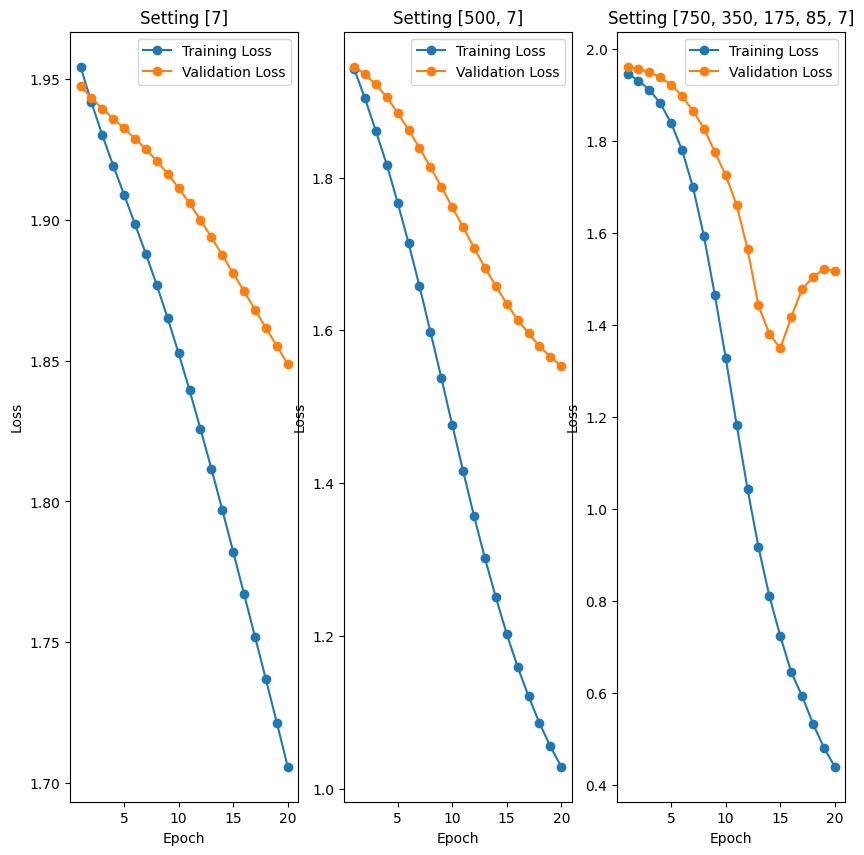

In [68]:
# changing the seed
torch.manual_seed(62)
train_loss_62, val_loss_62, test_acc_score_62 = train_for_setting(no_of_layers, hidden_dims, input_dim,
                                                         total_classes, adj, feature_mat, train_mask,
                                                         val_mask, test_mask, dropout_prob)

# plot for all setting
plt.subplots(1, 3, figsize=(10, 10))

for idx in range(len(test_acc_score)):
  plt.subplot(1, 3, idx + 1)
  plt.plot(
      range(1, 1 + len(train_loss_62[idx])),
      train_loss_62[idx],
      marker = 'o',
      label = "Training Loss"
  )

  plt.plot(
      range(1, 1 + len(val_loss_62[idx])),
      val_loss_62[idx],
      marker = 'o',
      label = "Validation Loss"
  )

  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()
  plt.title(f"Setting {hidden_dims[idx]}")

plt.show()

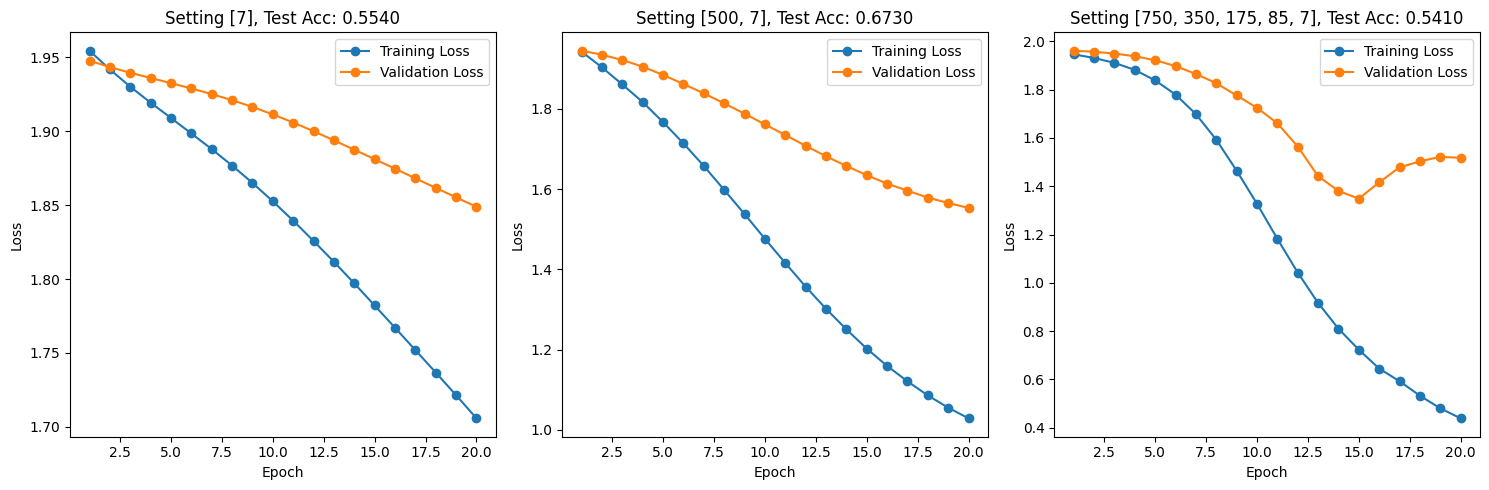

In [71]:
import matplotlib.pyplot as plt

# for i, acc in zip(hidden_dims, test_acc_score):
#   print(f"Under Setting {i}, test accuracy - {acc}")
#   print("="*80)

plt.subplots(1, 3, figsize=(15, 5))

for idx in range(len(test_acc_score)):
    plt.subplot(1, 3, idx + 1)
    plt.plot(
        range(1, 1 + len(train_loss_62[idx])),
        train_loss_62[idx],
        marker='o',
        label="Training Loss"
    )

    plt.plot(
        range(1, 1 + len(val_loss_62[idx])),
        val_loss_62[idx],
        marker='o',
        label="Validation Loss"
    )

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"Setting {hidden_dims[idx]}, Test Acc: {test_acc_score[idx]:.4f}")

plt.tight_layout()
plt.show()


In [69]:

for i, acc in zip(hidden_dims, test_acc_score):
  print(f"Under Setting {i}, test accuracy - {acc}")
  print("="*80)

Under Setting [7], test accuracy - 0.554
Under Setting [500, 7], test accuracy - 0.673
Under Setting [750, 350, 175, 85, 7], test accuracy - 0.541


In [72]:
torch.manual_seed(80)
train_loss_80, val_loss_80, test_acc_score_80 = train_for_setting(no_of_layers, hidden_dims, input_dim,
                                                         total_classes, adj, feature_mat, train_mask,
                                                         val_mask, test_mask, dropout_prob)



Initiating for setting - 1 with Hidden Dims [7]
EPOCH - 1
Training Loss 1.9311922788619995, Validation Loss 1.9365341663360596
--------------------------------------------------------------------------------
EPOCH - 2
Training Loss 1.915305256843567, Validation Loss 1.9314563274383545
--------------------------------------------------------------------------------
EPOCH - 3
Training Loss 1.8995387554168701, Validation Loss 1.9261683225631714
--------------------------------------------------------------------------------
EPOCH - 4
Training Loss 1.8837659358978271, Validation Loss 1.9207370281219482
--------------------------------------------------------------------------------
EPOCH - 5
Training Loss 1.867880940437317, Validation Loss 1.9151302576065063
--------------------------------------------------------------------------------
EPOCH - 6
Training Loss 1.851906418800354, Validation Loss 1.909224510192871
-----------------------------------------------------------------------------

Under Setting [7], test accuracy - 0.554
Under Setting [500, 7], test accuracy - 0.673
Under Setting [750, 350, 175, 85, 7], test accuracy - 0.541


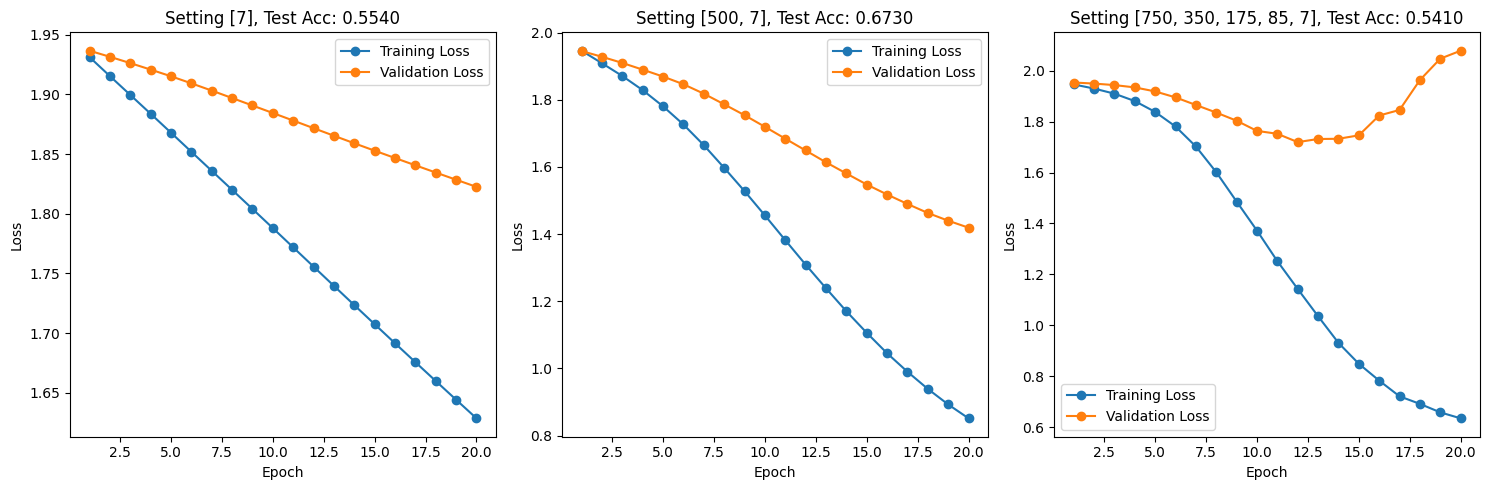

In [79]:


for i, acc in zip(hidden_dims, test_acc_score):
  print(f"Under Setting {i}, test accuracy - {acc}")
  print("="*80)

plt.subplots(1, 3, figsize=(15, 5))

for idx in range(len(test_acc_score)):
    plt.subplot(1, 3, idx + 1)
    plt.plot(
        range(1, 1 + len(train_loss_80[idx])),
        train_loss_80[idx],
        marker='o',
        label="Training Loss"
    )

    plt.plot(
        range(1, 1 + len(val_loss_80[idx])),
        val_loss_80[idx],
        marker='o',
        label="Validation Loss"
    )

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"Setting {hidden_dims[idx]}, Test Acc: {test_acc_score[idx]:.4f}")

plt.tight_layout()
plt.show()


In [74]:
for dims, test_acc in zip(hidden_dims, test_acc_score_80):
  print(f"Under Setting {dims}, test accuracy - {test_acc}")
  print("------------------------")

Under Setting [7], test accuracy - 0.68
------------------------
Under Setting [500, 7], test accuracy - 0.586
------------------------
Under Setting [750, 350, 175, 85, 7], test accuracy - 0.51
------------------------


In [77]:
import numpy as np

# Test accuracies with different settings and seeds
test_accuracies = {
    "Setting [7]": [0.588, 0.6, 0.554],
    "Setting [500, 7]": [0.579, 0.428, 0.673],
    "Setting [750, 350, 175, 85, 7]": [0.678, 0.672, 0.541]
}

# Print test accuracies for each setting and seed
for setting, accuracies in test_accuracies.items():
    print(f"{setting}:")
    for i, acc in enumerate(accuracies, start=1):
        print(f"  With seed {i}: test accuracy - {acc}")
    print("="*80)

# Calculate and print mean and standard deviation for each setting
for setting, accuracies in test_accuracies.items():
    mean_acc = np.mean(np.array(accuracies))
    std_acc = np.std(np.array(accuracies))
    print(f"Mean for {setting} - {mean_acc}")
    print(f"Standard deviation for {setting} - {std_acc}")
    print()


Setting [7]:
  With seed 1: test accuracy - 0.588
  With seed 2: test accuracy - 0.6
  With seed 3: test accuracy - 0.554
Setting [500, 7]:
  With seed 1: test accuracy - 0.579
  With seed 2: test accuracy - 0.428
  With seed 3: test accuracy - 0.673
Setting [750, 350, 175, 85, 7]:
  With seed 1: test accuracy - 0.678
  With seed 2: test accuracy - 0.672
  With seed 3: test accuracy - 0.541
Mean for Setting [7] - 0.5806666666666667
Standard deviation for Setting [7] - 0.019482185594936578

Mean for Setting [500, 7] - 0.5599999999999999
Standard deviation for Setting [500, 7] - 0.10091910952176833

Mean for Setting [750, 350, 175, 85, 7] - 0.6303333333333333
Standard deviation for Setting [750, 350, 175, 85, 7] - 0.06321568019267232



In [80]:
no_of_layers = [1,2,5]
hidden_dims = [[7], [500, 7], [750, 350, 175, 85, 7]]
dropout_prob = None
input_dim = 1433
total_classes = 7

torch.manual_seed(42)

train_loss, val_loss, test_acc_score = train_for_setting(no_of_layers, hidden_dims, input_dim,
                                                         total_classes, adj, feature_mat, train_mask,
                                                         val_mask, test_mask, dropout_prob)



Initiating for setting - 1 with Hidden Dims [7]
EPOCH - 1
Training Loss 1.9489153623580933, Validation Loss 1.9420157670974731
--------------------------------------------------------------------------------
EPOCH - 2
Training Loss 1.9396743774414062, Validation Loss 1.938591718673706
--------------------------------------------------------------------------------
EPOCH - 3
Training Loss 1.9314172267913818, Validation Loss 1.9355446100234985
--------------------------------------------------------------------------------
EPOCH - 4
Training Loss 1.9236781597137451, Validation Loss 1.9325199127197266
--------------------------------------------------------------------------------
EPOCH - 5
Training Loss 1.9158177375793457, Validation Loss 1.9294450283050537
--------------------------------------------------------------------------------
EPOCH - 6
Training Loss 1.907158374786377, Validation Loss 1.9260674715042114
---------------------------------------------------------------------------

Under Setting [7], test accuracy - 0.554
Under Setting [500, 7], test accuracy - 0.674
Under Setting [750, 350, 175, 85, 7], test accuracy - 0.628


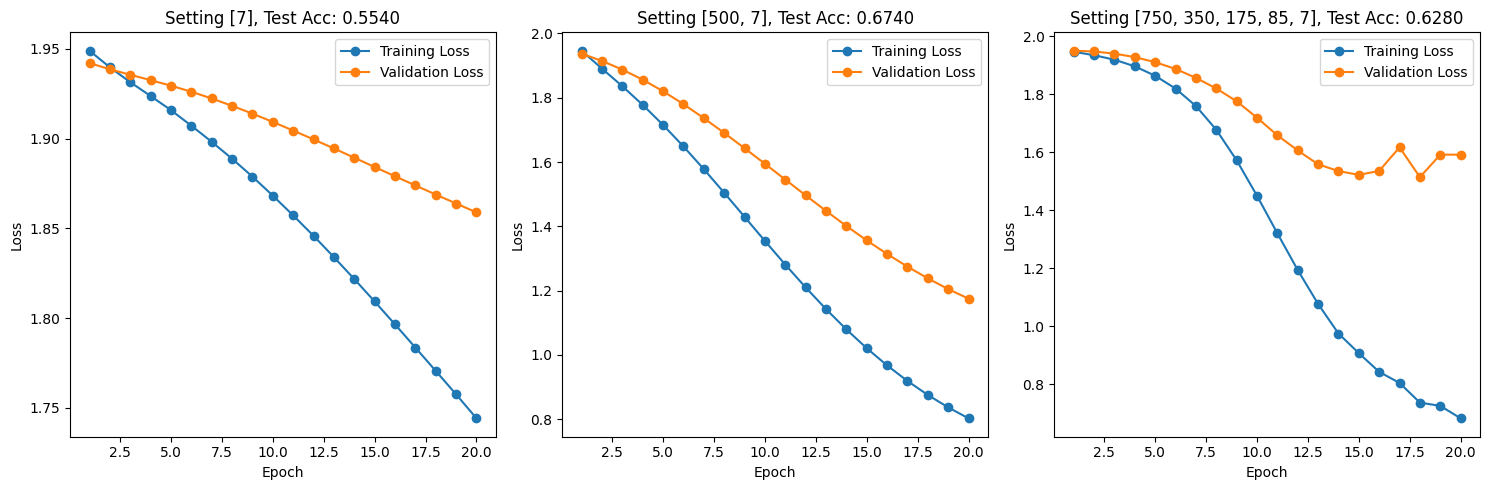

In [82]:



for i, acc in zip(hidden_dims, test_acc_score):
  print(f"Under Setting {i}, test accuracy - {acc}")
  print("="*80)

plt.subplots(1, 3, figsize=(15, 5))

for idx in range(len(test_acc_score)):
    plt.subplot(1, 3, idx + 1)
    plt.plot(
        range(1, 1 + len(train_loss[idx])),
        train_loss[idx],
        marker='o',
        label="Training Loss"
    )

    plt.plot(
        range(1, 1 + len(val_loss[idx])),
        val_loss[idx],
        marker='o',
        label="Validation Loss"
    )

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"Setting {hidden_dims[idx]}, Test Acc: {test_acc_score[idx]:.4f}")

plt.tight_layout()
plt.show()


In [83]:
no_of_layers = [1,2,5]
hidden_dims = [[7], [500, 7], [750, 350, 175, 85, 7]]
dropout_prob = None
input_dim = 1433
total_classes = 7

torch.manual_seed(62)

train_loss_62, val_loss_62, test_acc_score_62 = train_for_setting(no_of_layers, hidden_dims, input_dim,
                                                         total_classes, adj, feature_mat, train_mask,
                                                         val_mask, test_mask, dropout_prob)








# plt.subplots(1, 3, figsize=(10, 10))

# for idx in range(len(test_acc_score_62)):
#   plt.subplot(1, 3, idx + 1)
#   plt.plot(
#       range(1, 1 + len(train_loss_62[idx])),
#       train_loss_62[idx],
#       marker = 'o',
#       label = "Training Loss"
#   )

#   plt.plot(
#       range(1, 1 + len(val_loss_62[idx])),
#       val_loss_62[idx],
#       marker = 'o',
#       label = "Validation Loss"
#   )

#   plt.xlabel("Epoch")
#   plt.ylabel("Loss")
#   plt.legend()
#   plt.title(f"Setting {hidden_dims[idx]}")

# plt.show()

# # test accuracy
# for dims, test_acc in zip(hidden_dims, test_acc_score_62):
#   print(f"Under Setting {dims}, test accuracy - {test_acc}")
#   print("------------------------")


Initiating for setting - 1 with Hidden Dims [7]
EPOCH - 1
Training Loss 1.9544503688812256, Validation Loss 1.9477523565292358
--------------------------------------------------------------------------------
EPOCH - 2
Training Loss 1.9417811632156372, Validation Loss 1.9433586597442627
--------------------------------------------------------------------------------
EPOCH - 3
Training Loss 1.9301131963729858, Validation Loss 1.9395557641983032
--------------------------------------------------------------------------------
EPOCH - 4
Training Loss 1.9193073511123657, Validation Loss 1.9359948635101318
--------------------------------------------------------------------------------
EPOCH - 5
Training Loss 1.9089471101760864, Validation Loss 1.9325286149978638
--------------------------------------------------------------------------------
EPOCH - 6
Training Loss 1.898443341255188, Validation Loss 1.9289060831069946
--------------------------------------------------------------------------

Under Setting [7], test accuracy - 0.554
Under Setting [500, 7], test accuracy - 0.674
Under Setting [750, 350, 175, 85, 7], test accuracy - 0.628


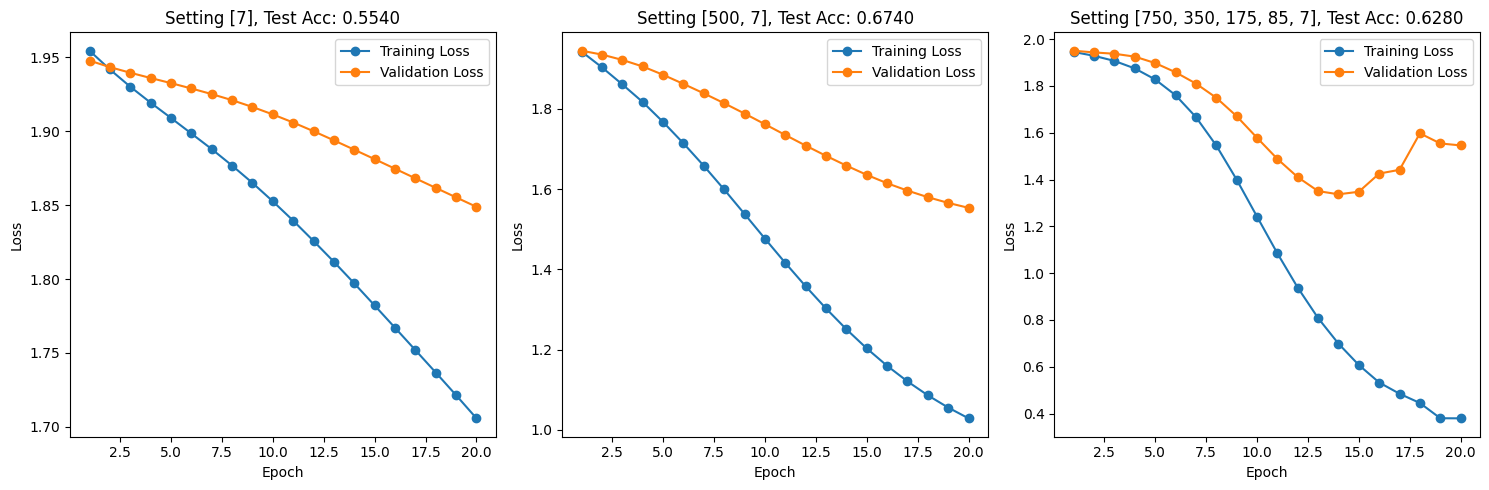

In [84]:
for i, acc in zip(hidden_dims, test_acc_score):
  print(f"Under Setting {i}, test accuracy - {acc}")
  print("="*80)

plt.subplots(1, 3, figsize=(15, 5))

for idx in range(len(test_acc_score)):
    plt.subplot(1, 3, idx + 1)
    plt.plot(
        range(1, 1 + len(train_loss_62[idx])),
        train_loss_62[idx],
        marker='o',
        label="Training Loss"
    )

    plt.plot(
        range(1, 1 + len(val_loss_62[idx])),
        val_loss_62[idx],
        marker='o',
        label="Validation Loss"
    )

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"Setting {hidden_dims[idx]}, Test Acc: {test_acc_score[idx]:.4f}")

plt.tight_layout()
plt.show()

In [85]:
# without dropout

no_of_layers = [1,2,5]
hidden_dims = [[7], [500, 7], [750, 350, 175, 85, 7]]
dropout_prob = None
input_dim = 1433
total_classes = 7

torch.manual_seed(72)

train_loss_72, val_loss_72, test_acc_score_72 = train_for_setting(no_of_layers, hidden_dims, input_dim,
                                                         total_classes, adj, feature_mat, train_mask,
                                                         val_mask, test_mask, dropout_prob)



Initiating for setting - 1 with Hidden Dims [7]
EPOCH - 1
Training Loss 1.9457331895828247, Validation Loss 1.9485119581222534
--------------------------------------------------------------------------------
EPOCH - 2
Training Loss 1.9343593120574951, Validation Loss 1.9443539381027222
--------------------------------------------------------------------------------
EPOCH - 3
Training Loss 1.9233806133270264, Validation Loss 1.9404103755950928
--------------------------------------------------------------------------------
EPOCH - 4
Training Loss 1.912352204322815, Validation Loss 1.9364893436431885
--------------------------------------------------------------------------------
EPOCH - 5
Training Loss 1.901193618774414, Validation Loss 1.9323853254318237
--------------------------------------------------------------------------------
EPOCH - 6
Training Loss 1.8896846771240234, Validation Loss 1.92798912525177
-----------------------------------------------------------------------------

Under Setting [7], test accuracy - 0.554
Under Setting [500, 7], test accuracy - 0.674
Under Setting [750, 350, 175, 85, 7], test accuracy - 0.628


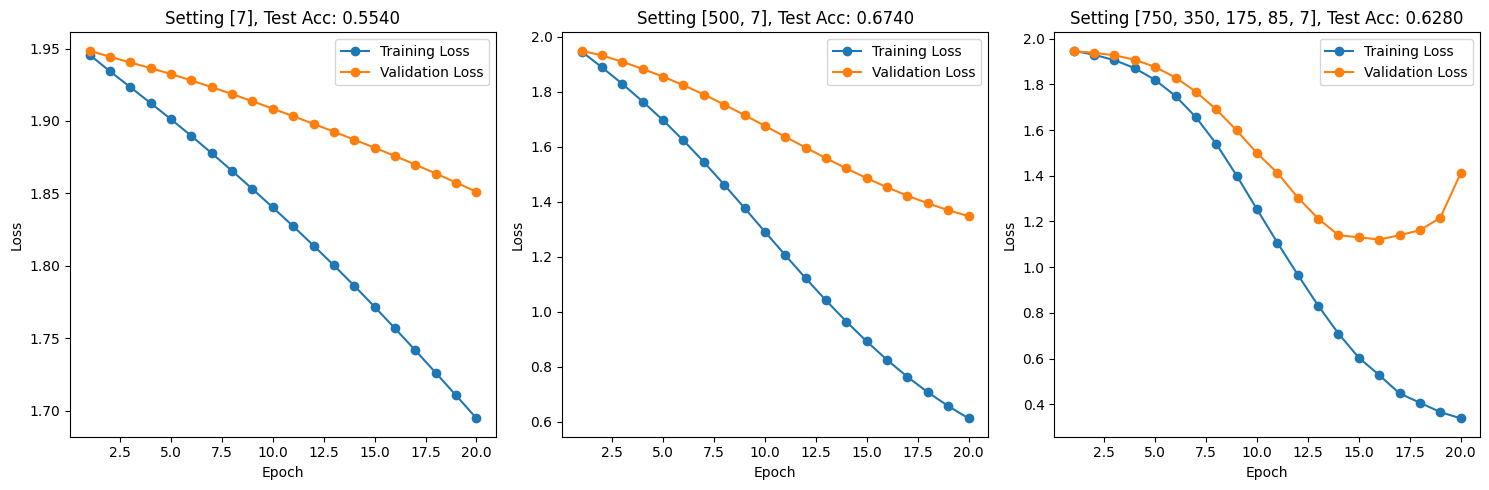

In [86]:
# # plot for all setting
# plt.subplots(1, 3, figsize=(10, 10))

# for idx in range(len(test_acc_score_72)):
#   plt.subplot(1, 3, idx + 1)
#   plt.plot(
#       range(1, 1 + len(train_loss_72[idx])),
#       train_loss_72[idx],
#       marker = 'o',
#       label = "Training Loss"
#   )

#   plt.plot(
#       range(1, 1 + len(val_loss_72[idx])),
#       val_loss_72[idx],
#       marker = 'o',
#       label = "Validation Loss"
#   )

#   plt.xlabel("Epoch")
#   plt.ylabel("Loss")
#   plt.legend()
#   plt.title(f"Setting {hidden_dims[idx]}")

# plt.show()

# # test accuracy
# for dims, test_acc in zip(hidden_dims, test_acc_score_72):
#   print(f"Under Setting {dims}, test accuracy - {test_acc}")
#   print("------------------------")





for i, acc in zip(hidden_dims, test_acc_score):
  print(f"Under Setting {i}, test accuracy - {acc}")
  print("="*80)

plt.subplots(1, 3, figsize=(15, 5))

for idx in range(len(test_acc_score)):
    plt.subplot(1, 3, idx + 1)
    plt.plot(
        range(1, 1 + len(train_loss_72[idx])),
        train_loss_72[idx],
        marker='o',
        label="Training Loss"
    )

    plt.plot(
        range(1, 1 + len(val_loss_72[idx])),
        val_loss_72[idx],
        marker='o',
        label="Validation Loss"
    )

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"Setting {hidden_dims[idx]}, Test Acc: {test_acc_score[idx]:.4f}")

plt.tight_layout()
plt.show()

In [87]:
print("Without Dropout")

print("With seed 72")
print("Under Setting [7], test accuracy - 0.554")
print("Under Setting [500, 7], test accuracy - 0.674")
print("Under Setting [750, 350, 175, 85, 7], test accuracy - 0.628")
print("-"*80)

print("With seed 62")
print("Under Setting [7], test accuracy - 0.6")
print("Under Setting [500, 7], test accuracy - 0.428")
print("Under Setting [750, 350, 175, 85, 7], test accuracy - 0.64")
print("-"*80)


print("With seed 42")
print("Under Setting [7], test accuracy - 0.588")
print("Under Setting [500, 7], test accuracy - 0.579")
print("Under Setting [750, 350, 175, 85, 7], test accuracy - 0.724")
print("-"*80)


print("\n\n\n")
print("Mean for [7] - ", np.mean(np.array([0.554, 0.674, 0.628])))
print("Standard deviation for [7] - ", np.std(np.array([0.554, 0.674, 0.628])))

print("\nMean for [500, 7] - ", np.mean(np.array([0.6, 0.428, 0.64])))
print("Standard deviation for [500, 7] - ", np.std(np.array([0.6, 0.428, 0.64])))

print("\nMean for [750, 350, 175, 85, 7] - ", np.mean(np.array([0.588, 0.579, 0.724])))
print("Standard deviation for [750, 350, 175, 85, 7] - ", np.std(np.array([0.588, 0.579, 0.724])))



Without Dropout
With seed 72
Under Setting [7], test accuracy - 0.554
Under Setting [500, 7], test accuracy - 0.674
Under Setting [750, 350, 175, 85, 7], test accuracy - 0.628
--------------------------------------------------------------------------------
With seed 62
Under Setting [7], test accuracy - 0.6
Under Setting [500, 7], test accuracy - 0.428
Under Setting [750, 350, 175, 85, 7], test accuracy - 0.64
--------------------------------------------------------------------------------
With seed 42
Under Setting [7], test accuracy - 0.588
Under Setting [500, 7], test accuracy - 0.579
Under Setting [750, 350, 175, 85, 7], test accuracy - 0.724
--------------------------------------------------------------------------------




Mean for [7] -  0.6186666666666668
Standard deviation for [7] -  0.04943233309844433

Mean for [500, 7] -  0.556
Standard deviation for [500, 7] -  0.09197100992522952

Mean for [750, 350, 175, 85, 7] -  0.6303333333333333
Standard deviation for [750, 350, 175

In [88]:
print("With dropput  = 0.01")

print("With seed 72")
print("Under Setting [7], test accuracy - 0.588")
print("Under Setting [500, 7], test accuracy - 0.579")
print("Under Setting [750, 350, 175, 85, 7], test accuracy - 0.678")
print("-"*80)

print("With seed 62")
print("Under Setting [7], test accuracy - 0.6")
print("Under Setting [500, 7], test accuracy - 0.428")
print("Under Setting [750, 350, 175, 85, 7], test accuracy - 0.672")
print("-"*80)


print("With seed 42")
print("Under Setting [7], test accuracy - 0.554")
print("Under Setting [500, 7], test accuracy - 0.673")
print("Under Setting [750, 350, 175, 85, 7], test accuracy - 0.541")
print("-"*80)


print("\n\n\n")
print("Mean for [7] - ", np.mean(np.array([0.588, 0.6, 0.554])))
print("Standard deviation for [7] - ", np.std(np.array([0.588, 0.6, 0.554])))

print("\nMean for [500, 7] - ", np.mean(np.array([0.579, 0.428, 0.673])))
print("Standard deviation for [500, 7] - ", np.std(np.array([0.579, 0.428, 0.673])))

print("\nMean for [750, 350, 175, 85, 7] - ", np.mean(np.array([0.678, 0.672, 0.541])))
print("Standard deviation for [750, 350, 175, 85, 7] - ", np.std(np.array([0.678, 0.672, 0.541])))

With dropput  = 0.01
With seed 72
Under Setting [7], test accuracy - 0.588
Under Setting [500, 7], test accuracy - 0.579
Under Setting [750, 350, 175, 85, 7], test accuracy - 0.678
--------------------------------------------------------------------------------
With seed 62
Under Setting [7], test accuracy - 0.6
Under Setting [500, 7], test accuracy - 0.428
Under Setting [750, 350, 175, 85, 7], test accuracy - 0.672
--------------------------------------------------------------------------------
With seed 42
Under Setting [7], test accuracy - 0.554
Under Setting [500, 7], test accuracy - 0.673
Under Setting [750, 350, 175, 85, 7], test accuracy - 0.541
--------------------------------------------------------------------------------




Mean for [7] -  0.5806666666666667
Standard deviation for [7] -  0.019482185594936578

Mean for [500, 7] -  0.5599999999999999
Standard deviation for [500, 7] -  0.10091910952176833

Mean for [750, 350, 175, 85, 7] -  0.6303333333333333
Standard deviatio

In [89]:
# changing dropout probabity  and using 5 hidden layer

drop_out = 0.02

no_of_layers = 5
hidden_dims = [750, 350, 175, 85, 7]
dropout_prob = 0.02
input_dim = 1433
total_classes = 7

torch.manual_seed(72)

train_loss_72, val_loss_72, test_acc_score_72 = start_train(no_of_layers, input_dim, hidden_dims, total_classes,
                                                            train_mask, val_mask, test_mask, adj, dropout_prob)


EPOCH - 1
Training Loss 1.947229266166687, Validation Loss 1.944887399673462
--------------------------------------------------------------------------------
EPOCH - 2
Training Loss 1.9377528429031372, Validation Loss 1.9422852993011475
--------------------------------------------------------------------------------
EPOCH - 3
Training Loss 1.9231985807418823, Validation Loss 1.9406564235687256
--------------------------------------------------------------------------------
EPOCH - 4
Training Loss 1.9010262489318848, Validation Loss 1.933988094329834
--------------------------------------------------------------------------------
EPOCH - 5
Training Loss 1.8692137002944946, Validation Loss 1.9198275804519653
--------------------------------------------------------------------------------
EPOCH - 6
Training Loss 1.8272393941879272, Validation Loss 1.8968710899353027
--------------------------------------------------------------------------------
EPOCH - 7
Training Loss 1.768218755722046, 

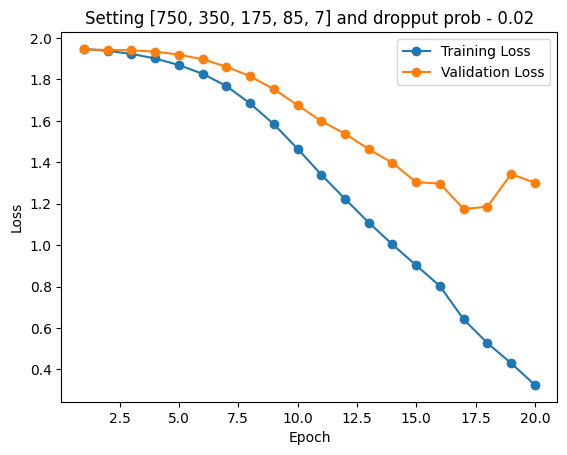

Test accuracy - 0.742


In [94]:

# Loss Plot
plt.plot(
      range(1, 1 + len(train_loss_72)),
      train_loss_72,
      marker = 'o',
      label = "Training Loss"
)

plt.plot(
    range(1, 1 + len(val_loss_72)),
    val_loss_72,
    marker = 'o',
    label = "Validation Loss"
)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title(f"Setting {hidden_dims} and dropput prob - {dropout_prob}")

plt.show()

# test accuracy
print(f"Test accuracy - {test_acc_score_72}")

EPOCH - 1
Training Loss 1.9475274085998535, Validation Loss 1.944817066192627
-----------------------------------
EPOCH - 2
Training Loss 1.9378917217254639, Validation Loss 1.9422341585159302
-----------------------------------
EPOCH - 3
Training Loss 1.9239685535430908, Validation Loss 1.9407185316085815
-----------------------------------
EPOCH - 4
Training Loss 1.9034618139266968, Validation Loss 1.9344033002853394
-----------------------------------
EPOCH - 5
Training Loss 1.8712478876113892, Validation Loss 1.9217416048049927
-----------------------------------
EPOCH - 6
Training Loss 1.8299708366394043, Validation Loss 1.9010887145996094
-----------------------------------
EPOCH - 7
Training Loss 1.7741104364395142, Validation Loss 1.874780297279358
-----------------------------------
EPOCH - 8
Training Loss 1.6949405670166016, Validation Loss 1.8341357707977295
-----------------------------------
EPOCH - 9
Training Loss 1.601128339767456, Validation Loss 1.781134009361267
-----

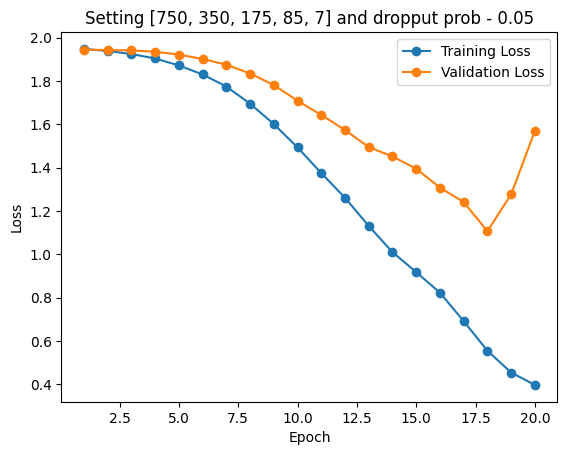

Test accuracy - 0.591


In [ ]:
# changing dropout probabity  and using 5 hidden layer

drop_out = 0.05

no_of_layers = 5
hidden_dims = [750, 350, 175, 85, 7]
dropout_prob = 0.05
input_dim = 1433
total_classes = 7

torch.manual_seed(72)

train_loss_72, val_loss_72, test_acc_score_72 = start_train(no_of_layers, input_dim, hidden_dims, total_classes,
                                                            train_mask, val_mask, test_mask, adj, dropout_prob)

# Loss Plot
plt.plot(
      range(1, 1 + len(train_loss_72)),
      train_loss_72,
      marker = 'o',
      label = "Training Loss"
)

plt.plot(
    range(1, 1 + len(val_loss_72)),
    val_loss_72,
    marker = 'o',
    label = "Validation Loss"
)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title(f"Setting {hidden_dims} and dropput prob - {dropout_prob}")

plt.show()

# test accuracy
print(f"Test accuracy - {test_acc_score_72}")

dropout works


4th part

Comparing GCN with GraphSAGE involves evaluating their performance on a specific task or dataset. Here's a general comparison based on common characteristics of both models:

### Graph Convolutional Networks (GCN):

#### Aggregation Method: GCN uses a mean aggregation strategy, which aggregates features from neighboring nodes by averaging them.
#### Scalability: GCNs are computationally expensive for large graphs due to the need to compute the normalized adjacency matrix.
#### Expressiveness: Limited expressive power compared to more advanced methods like Graph Attention Networks (GAT) and Graph Isomorphism Networks (GIN).
#### Sample Efficiency: GCNs may struggle with learning representations for nodes with limited labeled data, as they rely heavily on labeled examples for training.


### GraphSAGE:

#### Aggregation Method:
####GraphSAGE offers flexibility in aggregation methods, such as mean, LSTM-based, or pooling, allowing it to capture different neighborhood structures.

### Scalability: GraphSAGE can be more scalable than GCNs, especially with the "Sample and Aggregate" approach, which allows it to work with large graphs efficiently.

### Expressiveness: GraphSAGE can capture more complex patterns in the graph compared to GCNs, especially with more advanced aggregation methods.
Sample Efficiency: GraphSAGE can generalize better with limited labeled data, as it can leverage information from the entire graph neighborhood.


### In summary, GraphSAGE's flexibility in aggregation methods and scalability make it a strong contender against GCNs, especially for large graphs or tasks requiring more expressive power. However, the effectiveness of each model depends heavily on the specific dataset and task at hand.

In [95]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader
from torch_geometric.nn import GCNConv, SAGEConv, GINConv, GATConv
from sklearn.metrics import accuracy_score

# Load the dataset
dataset = Planetoid(root='./data', name='Cora', split='full')

# Define the models
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

class GraphSAGE(torch.nn.Module):
    def __init__(self):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(dataset.num_features, 16)
        self.conv2 = SAGEConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)



In [96]:

# Instantiate the models
gcn_model = GCN()
graphsage_model = GraphSAGE()

# Define the optimizer and loss function
optimizer_gcn = torch.optim.Adam(gcn_model.parameters(), lr=0.01)
optimizer_graphsage = torch.optim.Adam(graphsage_model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Train the models
def train(model, optimizer):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

for epoch in range(200):
    loss_gcn = train(gcn_model, optimizer_gcn)
    loss_graphsage = train(graphsage_model, optimizer_graphsage)



In [97]:
# Evaluate the models
def test(model):
    model.eval()
    out = model(data)
    pred = out.argmax(dim=1)
    acc = accuracy_score(data.y[data.test_mask].numpy(), pred[data.test_mask].numpy())
    return acc

acc_gcn = test(gcn_model)
acc_graphsage = test(graphsage_model)

print(f'GCN Test Accuracy: {acc_gcn}')
print(f'GraphSAGE Test Accuracy: {acc_graphsage}')

GCN Test Accuracy: 0.773
GraphSAGE Test Accuracy: 0.736


#GAT: Why is the method better/worse/equal as compared to GCN? 3 marks

The effectiveness of GraphSAGE compared to GCN depends on several factors, including the characteristics of the dataset and the specific task at hand. Here's a more detailed comparison of GraphSAGE and GCN:

GraphSAGE:

Flexibility in Aggregation Methods: GraphSAGE offers multiple aggregation methods (e.g., mean, LSTM-based, pooling), allowing it to capture different neighborhood structures. This flexibility can lead to better performance in tasks where different types of neighborhood information are important.

Scalability: GraphSAGE can be more scalable than GCNs, especially with the "Sample and Aggregate" approach, which allows it to work efficiently with large graphs. This scalability can be crucial for handling real-world graphs with millions of nodes and edges.

Expressiveness: GraphSAGE can capture more complex patterns in the graph compared to GCNs, especially with its ability to aggregate information from a node's entire neighborhood. This increased expressiveness can lead to better performance in tasks that require capturing intricate graph structures.

Sample Efficiency: GraphSAGE can generalize better with limited labeled data, as it can leverage information from the entire graph neighborhood. This can be advantageous in scenarios where labeled data is scarce or expensive to obtain.

GCN:

Simplicity and Interpretability: GCNs are relatively simple and easy to interpret compared to more complex models like GraphSAGE. This simplicity can be beneficial in scenarios where a clear understanding of the model's behavior is important.

Computationally Less Expensive: GCNs are computationally less expensive than some GraphSAGE variants, especially when using the basic mean aggregation method. This can be advantageous in scenarios where computational resources are limited.

Effectiveness in Homophily-based Tasks: GCNs perform well in tasks where the homophily principle (nodes with similar attributes are more likely to be connected) holds true, as they effectively propagate information through graph connections based on node attributes.

In summary, GraphSAGE's flexibility, scalability, and expressiveness make it a strong candidate for tasks requiring complex graph reasoning and handling large graphs. However, GCNs can still be effective in simpler tasks or scenarios where interpretability and computational efficiency are key considerations. The choice between the two models depends on the specific requirements and constraints of the problem at hand.

## GAT: What are the important hyperparameters for GAT (at least 2)? How does performance change across them? 3 marks

Graph Attention Network (GAT):

Important Hyperparameters:

Number of Attention Heads: The number of attention heads (K) determines the number of parallel attention mechanisms the model can use to aggregate information from neighbors. Increasing K can enhance the model's ability to capture diverse patterns in the graph but also increases the computational complexity.

Attention Mechanism Type: The type of attention mechanism used in GAT (e.g., additive or scaled dot-product attention) can significantly impact performance. Different attention mechanisms have different computational costs and may perform better or worse depending on the dataset and task.

Performance Variation:

Number of Attention Heads: Increasing the number of attention heads can lead to improved performance up to a certain point. However, adding more attention heads beyond a certain threshold may not provide further benefits and can lead to increased computational complexity without significant gains in performance.

Attention Mechanism Type: The choice of attention mechanism can also affect performance. For example, the scaled dot-product attention mechanism is computationally efficient but may struggle with long-range dependencies, while additive attention mechanisms can capture more complex patterns but are more computationally expensive.

Overall, the choice of hyperparameters in GAT, particularly the number of attention heads and the attention mechanism type, should be carefully tuned based on the dataset and task requirements to achieve the best performance.

## GIN: Are there important hyperparameters for GIN? What are they and how does performance change? 3 marks

Graph Isomorphism Network (GIN):

Important Hyperparameters:

Depth of Message Passing Layers: The depth of message passing layers (i.e., the number of layers in the neural network) is a crucial hyperparameter in GIN. Increasing the depth allows the model to capture more complex graph structures but may also lead to overfitting or vanishing gradients.

Hidden Dimension Size: The size of the hidden dimensions in the message passing layers can significantly impact the model's performance. Larger hidden dimensions can capture more intricate graph features but may require more data and computational resources.

Performance Variation:

Depth of Message Passing Layers: Increasing the depth of message passing layers can initially improve the model's performance by allowing it to capture more complex graph patterns. However, beyond a certain depth, the performance may start to degrade due to overfitting or vanishing gradients. Therefore, the depth should be carefully tuned based on the dataset and task requirements.

Hidden Dimension Size: Increasing the hidden dimension size can also lead to improved performance as the model can capture more detailed graph features. However, larger hidden dimensions require more computational resources and data to train effectively. It's essential to balance the hidden dimension size with the available resources and dataset size.

Overall, tuning the depth of message passing layers and the hidden dimension size in GIN is crucial for achieving optimal performance, and these hyperparameters should be selected based on the specific characteristics of the dataset and task.